In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Preprocessing Test

In [20]:
X = {'building_id':[100],'meter':[0],'timestamp':['2017-12-02 12:00:00']}

In [21]:
def preprocess(X):

    weather_preproc = pd.read_csv('../raw_data/weather_preproc.csv', parse_dates=['timestamp'])

    building_preproc = pd.read_csv("../raw_data/building_preproc.csv")


    X = pd.DataFrame.from_dict(X)
    
    X['timestamp'] = pd.to_datetime(X.timestamp)
    row = X.merge(building_preproc.iloc[:,1:], on='building_id', how='left')

    row = row.merge(weather_preproc.iloc[:,1:], on=['site_id', 'timestamp'], how='left')

    beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
              (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

    for item in beaufort:
        row.loc[(row['wind_speed']>=item[1]) & (row['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

    row["timestamp"] = pd.to_datetime(row["timestamp"])

    def transform(df):
        df['hour'] = np.uint8(df['timestamp'].dt.hour)
        df['day'] = np.uint8(df['timestamp'].dt.day)
        df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
        df['month'] = np.uint8(df['timestamp'].dt.month)
        df['year'] = np.uint8(df['timestamp'].dt.year-1900)

        df['square_feet'] = np.log(df['square_feet'])

        return df

    row = transform(row)

    def encode_cyclic_feature(df, col, max_vals):
        df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    #     df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
        del df[col]
        return df

    dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
    us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

    row['is_holiday'] = (row['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
    row['is_holiday'] = (row['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

    row.loc[(row['weekday']) == 5 | (row['weekday'] == 6) , 'is_holiday'] = 1

    row = row.drop(['timestamp'], axis=1)

    row = encode_cyclic_feature(row, 'weekday', 7)
    row = encode_cyclic_feature(row, 'hour', 24)
    row = encode_cyclic_feature(row, 'day', 31)
    row = encode_cyclic_feature(row, 'month', 12)

    row = row.loc[:,['site_id', 'building_id', 'primary_use', 'meter', 'wind_direction',
           'is_holiday', 'square_feet', 'year_built', 'air_temperature',
           'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'floor_count',
           'beaufort_scale', 'weekday_sin', 'day_sin', 'hour_sin', 'month_sin']]
    return row

In [23]:
X = preprocess(X)

AttributeError: 'DataFrame' object has no attribute 'timestamp'

In [24]:
X

,site_id,building_id,primary_use,meter,wind_direction,is_holiday,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,floor_count,beaufort_scale,weekday_sin,day_sin,hour_sin,month_sin
0,0,100,4,0,0.0,0,10.104631,1968.0,22.8,2.0,18.3,0.0,4.0,0.0,-0.974928,0.394356,1.224647e-16,-2.449294e-16


In [6]:
def pred(X):
    model1 = lgb.Booster(model_file='../notebooks/model1.txt')
    model2 = lgb.Booster(model_file='../notebooks/model2.txt')
    y_pred = (model1.predict(X)+model2.predict(X))/2
    to_return = {'meter_reading':float(y_pred)}

    return to_return

In [31]:
X.primary_use= [1]

In [32]:
X

,site_id,building_id,primary_use,meter,wind_direction,is_holiday,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,floor_count,beaufort_scale,weekday_sin,day_sin,hour_sin,month_sin
0,0,100,1,0,0.0,0,10.104631,1968.0,22.8,2.0,18.3,0.0,4.0,0.0,-0.974928,0.394356,1.224647e-16,-2.449294e-16


In [33]:
pred(X)

{'meter_reading': 5.064354137618734}

In [36]:
model2 = lgb.Booster(model_file='../notebooks/model2.txt')

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

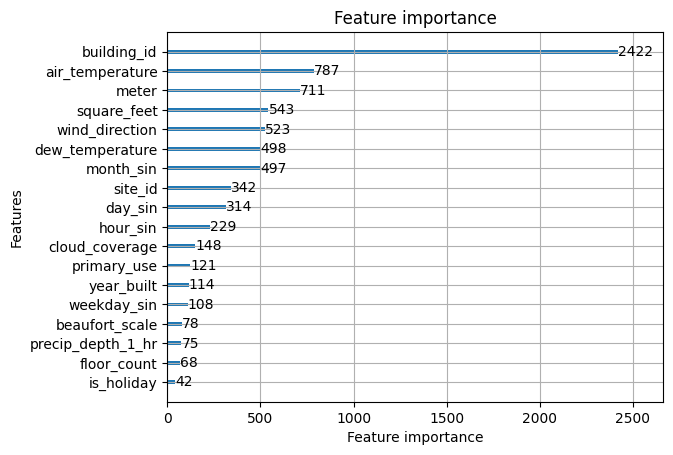

In [38]:
lgb.plot_importance(model1)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

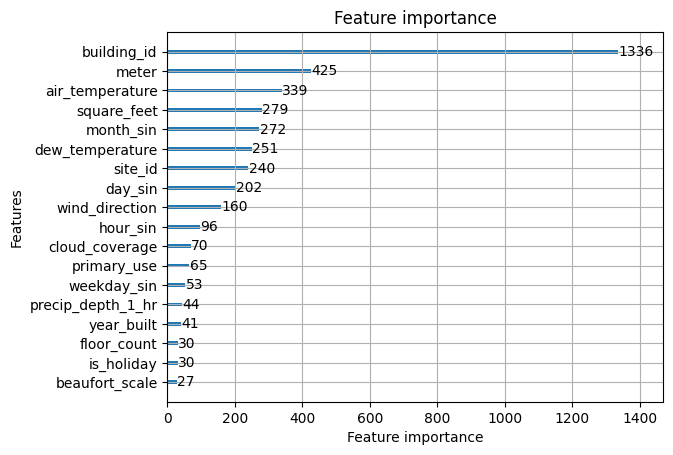

In [39]:
lgb.plot_importance(model2)

Ideas:

* Keep building ID: change primary use, change size. The closest to retrofit we can simulate.
* Change building ID: let's suppose someone had 